# Required Libraries

In [17]:
%pip install torch pandas numpy matplotlib scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [18]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
from collections import Counter
from sklearn.model_selection import train_test_split
import re
import matplotlib.pyplot as plt

# Data Processing Classes and Functions


In [19]:
class IMDBDataset(Dataset):
    """PyTorch Dataset for IMDB movie reviews"""
    def __init__(self, reviews, labels, vocab, max_length=200):
        self.reviews = reviews
        self.labels = labels
        self.vocab = vocab
        self.max_length = max_length
        
    def __len__(self):
        return len(self.reviews)
        
    def __getitem__(self, idx):
        review = self.reviews[idx]
        sequence = self.text_to_sequence(review)
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        return sequence, label
    
    def text_to_sequence(self, text):
        """Convert text to sequence of word indices"""
        words = text.split()
        sequence = [self.vocab.get(word, self.vocab['<unk>']) 
                   for word in words[:self.max_length]]
        
        # Pad sequence
        if len(sequence) < self.max_length:
            sequence += [self.vocab['<pad>']] * (self.max_length - len(sequence))
            
        return torch.tensor(sequence, dtype=torch.long)

def preprocess_text(text):
    """Clean and normalize text data"""
    text = text.lower()  # Convert to lowercase
    text = re.sub('<[^>]*>', '', text)  # Remove HTML tags
    text = re.sub('[^a-zA-Z\s]', '', text)  # Remove special characters
    return text.strip()

def build_vocabulary(texts, min_freq=5):
    """Build vocabulary from texts with minimum word frequency"""
    word_freq = {}
    for text in texts:
        for word in text.split():
            word_freq[word] = word_freq.get(word, 0) + 1
    
    # Create vocabulary with special tokens
    vocab = {'<pad>': 0, '<unk>': 1}
    for word, freq in word_freq.items():
        if freq >= min_freq:
            vocab[word] = len(vocab)
    
    return vocab

def prepare_data(file_path, max_length=200):
    """Load and prepare IMDB dataset"""
    # Load dataset
    df = pd.read_csv(file_path)
    
    # Preprocess reviews
    reviews = df['review'].apply(preprocess_text).values
    labels = (df['sentiment'] == 'positive').astype(int).values
    
    # Build vocabulary
    vocab = build_vocabulary(reviews)
    
    # Split data
    X_train, X_val, y_train, y_val = train_test_split(
        reviews, labels, test_size=0.2, random_state=42
    )
    
    # Create datasets
    train_dataset = IMDBDataset(X_train, y_train, vocab, max_length)
    val_dataset = IMDBDataset(X_val, y_val, vocab, max_length)
    
    return train_dataset, val_dataset, vocab

def create_dataloaders(train_dataset, val_dataset, batch_size=32):
    """Create DataLoader objects for training and validation"""
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True
    )
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False
    )
    
    return train_loader, val_loader

<>:34: SyntaxWarning: invalid escape sequence '\s'
<>:34: SyntaxWarning: invalid escape sequence '\s'
/var/folders/qz/ncpxlmfj0ln46r4kg3jylt140000gn/T/ipykernel_25694/3745075044.py:34: SyntaxWarning: invalid escape sequence '\s'
  text = re.sub('[^a-zA-Z\s]', '', text)  # Remove special characters


# Loading the Dataset

In [20]:
# Prepare datasets
train_dataset, val_dataset, vocab = prepare_data('data/IMDB-Datasetfull.csv')

# Create dataloaders
train_loader, val_loader = create_dataloaders(train_dataset, val_dataset)

print(f"Vocabulary size: {len(vocab)}")
print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")

Vocabulary size: 43792
Training samples: 40000
Validation samples: 10000


# Understanding Sequential Data and RNNs


In [21]:
def show_example_reviews(train_dataset, n=2):
    indices = np.random.randint(0, len(train_dataset), n)
    for idx in indices:
        sequence, label = train_dataset[idx]
        sentiment = "Positive" if label.item() == 1 else "Negative"
        print(f"Review (Sentiment: {sentiment}):")
        print(f"{' '.join([list(vocab.keys())[i] for i in sequence if i not in [0, 1]])}\n")

show_example_reviews(train_dataset)

Review (Sentiment: Positive):
what a strange atmosphere is being created in the streets and on the golden gate bridge of san francisco in this exciting action picture although the characters and the story are in fact bad it still has a certain

Review (Sentiment: Negative):
just what is the point of this film it starts off as one film then changes track cheating us of a resolution to that film and ends as another movie which is nothing but a pale pale imitation of so many other flicks youve ever seen the overall impression is confusion in every respect and a great deal of hubris screenplay by tarantino direction by rodriguez two guys who have previously shown talent but who now seem to believe their own hype and assume that whatever they do must be good merely because they did it but it doesnt quite work that way youre only good while you continue doing good things there are so many questions to ask just what are george clooney and harvey keitel doing getting involved in such pointless

# Traditional Neural Networks vs. RNNs


In [22]:
# Traditional feedforward network
class SimpleFFN(nn.Module):
    def __init__(self, vocab_size, hidden_size, output_size):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_size)
        self.fc = nn.Linear(hidden_size * 200, output_size)  # 200 is max_length
        
    def forward(self, x):
        # x shape: [batch_size, sequence_length]
        embedded = self.embedding(x)  # [batch_size, sequence_length, hidden_size]
        # Need to flatten because FFN can't handle sequences
        flattened = embedded.view(embedded.shape[0], -1)
        return self.fc(flattened)

# Basic RNN
class SimpleRNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size, output_size):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.RNN(embedding_dim, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        # x shape: [batch_size, sequence_length]
        embedded = self.embedding(x)  # [batch_size, sequence_length, embedding_dim]
        output, hidden = self.rnn(embedded)  # Process the sequence
        return self.fc(hidden.squeeze(0))

In [23]:
def manual_rnn_step(x_t, h_prev, W_xh, W_hh, b_h):
    """Compute one step of RNN manually"""
    # x_t: input at time t
    # h_prev: previous hidden state
    # W_xh: input-to-hidden weights
    # W_hh: hidden-to-hidden weights
    # b_h: bias
    
    # Combine input and hidden state calculations
    combined = torch.matmul(x_t, W_xh) + torch.matmul(h_prev, W_hh) + b_h
    
    # Apply tanh activation
    h_t = torch.tanh(combined)
    
    return h_t

# Example usage
batch_size = 2
input_size = 10
hidden_size = 20

# Random inputs and weights
x_t = torch.randn(batch_size, input_size)
h_prev = torch.randn(batch_size, hidden_size)
W_xh = torch.randn(input_size, hidden_size)
W_hh = torch.randn(hidden_size, hidden_size)
b_h = torch.randn(hidden_size)

# Compute one RNN step
h_t = manual_rnn_step(x_t, h_prev, W_xh, W_hh, b_h)
print("Hidden state shape:", h_t.shape)

Hidden state shape: torch.Size([2, 20])


# The Vanishing Gradient Problem


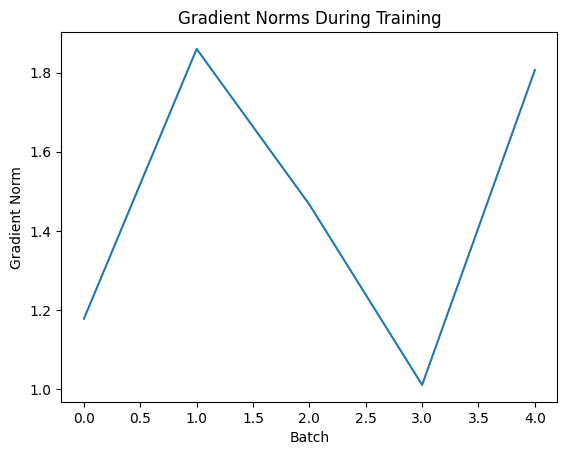

In [24]:
def train_simple_rnn():
    """Train a simple RNN and monitor gradients"""
    model = SimpleRNN(len(vocab), embedding_dim=100, hidden_size=256, output_size=2)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters())
    
    gradient_norms = []
    
    # Training loop
    for batch_idx, (text, labels) in enumerate(train_loader):
        if batch_idx >= 5:  # Just look at first few batches
            break
            
        optimizer.zero_grad()
        output = model(text)
        loss = criterion(output, labels)
        loss.backward()
        
        # Record gradient norms
        grad_norm = 0
        for param in model.rnn.parameters():
            if param.grad is not None:
                grad_norm += param.grad.norm().item()
        gradient_norms.append(grad_norm)
        
        optimizer.step()
    
    return gradient_norms

gradient_norms = train_simple_rnn()
plt.plot(gradient_norms)
plt.title('Gradient Norms During Training')
plt.xlabel('Batch')
plt.ylabel('Gradient Norm')
plt.show()

# Long Short-Term Memory (LSTM) Networks

In [25]:
class LSTMSentimentAnalyzer(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers=1, dropout=0.5):
        super().__init__()
        
        # Embedding layer converts word indices to dense vectors
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        # LSTM layer processes the sequence
        self.lstm = nn.LSTM(embedding_dim, 
                          hidden_dim, 
                          num_layers=n_layers, 
                          dropout=dropout if n_layers > 1 else 0,
                          batch_first=True)
        
        # Dropout layer for regularization
        self.dropout = nn.Dropout(dropout)
        
        # Linear layer for final prediction
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, text):
        # text shape: [batch size, sequence length]
        
        # Embed the text
        embedded = self.embedding(text)
        # embedded shape: [batch size, sequence length, embedding dim]
        
        # Pass through LSTM
        output, (hidden, cell) = self.lstm(embedded)
        # hidden shape: [n layers * n directions, batch size, hidden dim]
        
        # Apply dropout to hidden state
        hidden = self.dropout(hidden[-1,:,:])
        # hidden shape: [batch size, hidden dim]
        
        # Pass through linear layer
        return self.fc(hidden)

In [26]:
def train_lstm_model(train_loader, val_loader, vocab_size):
    # Model parameters
    EMBEDDING_DIM = 100
    HIDDEN_DIM = 256
    OUTPUT_DIM = 2
    N_LAYERS = 2
    DROPOUT = 0.5
    
    # Initialize model, criterion, and optimizer
    model = LSTMSentimentAnalyzer(vocab_size, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM, N_LAYERS, DROPOUT)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters())
    
    # Training history
    train_losses = []
    val_accuracies = []
    
    # Training loop
    for epoch in range(5):  # 5 epochs for demonstration
        # Training phase
        model.train()
        epoch_loss = 0
        for batch_idx, (text, labels) in enumerate(train_loader):
            optimizer.zero_grad()
            predictions = model(text)
            loss = criterion(predictions, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            
            # Print progress every 100 batches
            if batch_idx % 100 == 0:
                print(f'Epoch: {epoch+1}, Batch: {batch_idx}, Loss: {loss.item():.4f}')
        
        avg_epoch_loss = epoch_loss / len(train_loader)
        train_losses.append(avg_epoch_loss)
        
        # Validation phase
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for text, labels in val_loader:
                predictions = model(text)
                _, predicted = torch.max(predictions, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        accuracy = 100 * correct / total
        val_accuracies.append(accuracy)
        print(f'Epoch: {epoch+1}, Loss: {avg_epoch_loss:.4f}, Accuracy: {accuracy:.2f}%\n')
    
    return model, train_losses, val_accuracies

Epoch: 1, Batch: 0, Loss: 0.6906
Epoch: 1, Batch: 100, Loss: 0.7277
Epoch: 1, Batch: 200, Loss: 0.6945
Epoch: 1, Batch: 300, Loss: 0.6816
Epoch: 1, Batch: 400, Loss: 0.6812
Epoch: 1, Batch: 500, Loss: 0.6869
Epoch: 1, Batch: 600, Loss: 0.7006
Epoch: 1, Batch: 700, Loss: 0.6971
Epoch: 1, Batch: 800, Loss: 0.6997
Epoch: 1, Batch: 900, Loss: 0.6810
Epoch: 1, Batch: 1000, Loss: 0.7001
Epoch: 1, Batch: 1100, Loss: 0.6868
Epoch: 1, Batch: 1200, Loss: 0.7074
Epoch: 1, Loss: 0.6953, Accuracy: 50.39%

Epoch: 2, Batch: 0, Loss: 0.6948
Epoch: 2, Batch: 100, Loss: 0.6832
Epoch: 2, Batch: 200, Loss: 0.6895
Epoch: 2, Batch: 300, Loss: 0.6985
Epoch: 2, Batch: 400, Loss: 0.6978
Epoch: 2, Batch: 500, Loss: 0.6920
Epoch: 2, Batch: 600, Loss: 0.7095
Epoch: 2, Batch: 700, Loss: 0.7041
Epoch: 2, Batch: 800, Loss: 0.6800
Epoch: 2, Batch: 900, Loss: 0.7298
Epoch: 2, Batch: 1000, Loss: 0.6475
Epoch: 2, Batch: 1100, Loss: 0.6915
Epoch: 2, Batch: 1200, Loss: 0.6950
Epoch: 2, Loss: 0.6931, Accuracy: 49.61%

Epoc

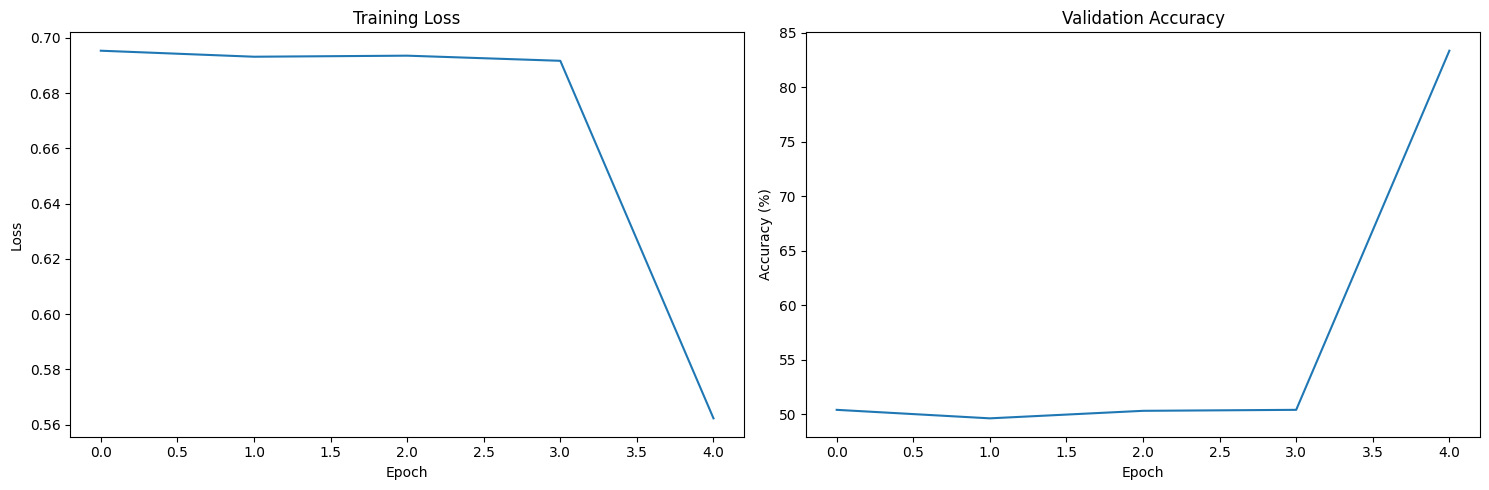

In [27]:
def plot_training_progress(train_losses, val_accuracies):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot training loss
    ax1.plot(train_losses)
    ax1.set_title('Training Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    
    # Plot validation accuracy
    ax2.plot(val_accuracies)
    ax2.set_title('Validation Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    
    plt.tight_layout()
    plt.show()

# Train the model and visualize results
model, train_losses, val_accuracies = train_lstm_model(train_loader, val_loader, len(vocab))
plot_training_progress(train_losses, val_accuracies)

# GRU 

In [28]:
class GRUSentimentAnalyzer(nn.Module):
	    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers=1, dropout=0.5):
	        super().__init__()
	        
	        # Embedding layer
	        self.embedding = nn.Embedding(vocab_size, embedding_dim)
	        
	        # GRU layer
	        self.gru = nn.GRU(embedding_dim,
	                         hidden_dim,
	                         num_layers=n_layers,
	                         dropout=dropout if n_layers > 1 else 0,
	                         batch_first=True)
	        
	        # Dropout layer
	        self.dropout = nn.Dropout(dropout)
	        
	        # Linear layer
	        self.fc = nn.Linear(hidden_dim, output_dim)
	        
	    def forward(self, text):
	        # Embed text
	        embedded = self.embedding(text)
	        
	        # Process through GRU
	        output, hidden = self.gru(embedded)
	        
	        # Apply dropout to final hidden state
	        hidden = self.dropout(hidden[-1,:,:])
	        
	        # Final prediction
	        return self.fc(hidden)


# Comparing LSTM and GRU Performance

In [29]:
def train_epoch(model, train_loader, criterion, optimizer):
    """Train model for one epoch and return average loss"""
    model.train()
    total_loss = 0
    
    for texts, labels in train_loader:
        optimizer.zero_grad()
        predictions = model(texts)
        loss = criterion(predictions, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    return total_loss / len(train_loader)

def evaluate_model(model, val_loader):
    """Evaluate model and return accuracy"""
    model.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        for texts, labels in val_loader:
            outputs = model(texts)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    return 100 * correct / total

def update_history(history, lstm_loss, gru_loss, lstm_acc, gru_acc, lstm_time, gru_time):
    """Update training history dictionary with new metrics"""
    history['lstm_loss'].append(lstm_loss)
    history['gru_loss'].append(gru_loss)
    history['lstm_acc'].append(lstm_acc)
    history['gru_acc'].append(gru_acc)
    history['lstm_time'].append(lstm_time)
    history['gru_time'].append(gru_time)

In [30]:
import time 

def compare_models():
    """Compare LSTM and GRU performance and training time"""
    # Model parameters
    EMBEDDING_DIM = 100
    HIDDEN_DIM = 256
    OUTPUT_DIM = 2
    N_LAYERS = 2
    DROPOUT = 0.5
    
    # Initialize models with identical parameters
    lstm_model = LSTMSentimentAnalyzer(len(vocab), EMBEDDING_DIM, HIDDEN_DIM, 
                                        OUTPUT_DIM, N_LAYERS, DROPOUT)
    gru_model = GRUSentimentAnalyzer(len(vocab), EMBEDDING_DIM, HIDDEN_DIM, 
                                    OUTPUT_DIM, N_LAYERS, DROPOUT)
    
    # Training setup
    criterion = nn.CrossEntropyLoss()
    lstm_optimizer = torch.optim.Adam(lstm_model.parameters())
    gru_optimizer = torch.optim.Adam(gru_model.parameters())
    
    # Track performance metrics
    history = {
        'lstm_loss': [], 'gru_loss': [],
        'lstm_acc': [], 'gru_acc': [],
        'lstm_time': [], 'gru_time': []
    }
    
    # Training loop
    for epoch in range(3):
        print(f'Epoch {epoch+1}:')
        
        # Train and time each model
        start_time = time.time()
        lstm_loss = train_epoch(lstm_model, train_loader, criterion, lstm_optimizer)
        lstm_time = time.time() - start_time
        lstm_acc = evaluate_model(lstm_model, val_loader)
        
        start_time = time.time()
        gru_loss = train_epoch(gru_model, train_loader, criterion, gru_optimizer)
        gru_time = time.time() - start_time
        gru_acc = evaluate_model(gru_model, val_loader)
        
        # Record metrics
        update_history(history, lstm_loss, gru_loss, lstm_acc, gru_acc, 
                        lstm_time, gru_time)
        
        print(f'LSTM - Loss: {lstm_loss:.4f}, Accuracy: {lstm_acc:.2f}%, Time: {lstm_time:.2f}s')
        print(f'GRU  - Loss: {gru_loss:.4f}, Accuracy: {gru_acc:.2f}%, Time: {gru_time:.2f}s\n')
    
    return history


In [31]:
def visualize_comparison(history):
    """Create comprehensive performance comparison visualizations"""
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
    
    # Training Loss Comparison
    ax1.plot(history['lstm_loss'], label='LSTM')
    ax1.plot(history['gru_loss'], label='GRU')
    ax1.set_title('Training Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    
    # Validation Accuracy Comparison
    ax2.plot(history['lstm_acc'], label='LSTM')
    ax2.plot(history['gru_acc'], label='GRU')
    ax2.set_title('Validation Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.legend()
    
    # Training Time Comparison
    ax3.bar(['LSTM', 'GRU'], 
            [np.mean(history['lstm_time']), np.mean(history['gru_time'])],
            yerr=[np.std(history['lstm_time']), np.std(history['gru_time'])])
    ax3.set_title('Average Training Time per Epoch')
    ax3.set_ylabel('Time (seconds)')
    
    # Cumulative Time
    cumulative_lstm = np.cumsum(history['lstm_time'])
    cumulative_gru = np.cumsum(history['gru_time'])
    ax4.plot(cumulative_lstm, label='LSTM')
    ax4.plot(cumulative_gru, label='GRU')
    ax4.set_title('Cumulative Training Time')
    ax4.set_xlabel('Epoch')
    ax4.set_ylabel('Time (seconds)')
    ax4.legend()
    
    plt.tight_layout()
    plt.show()


Epoch 1:
LSTM - Loss: 0.6932, Accuracy: 50.44%, Time: 188.67s
GRU  - Loss: 0.6716, Accuracy: 77.59%, Time: 173.54s

Epoch 2:
LSTM - Loss: 0.6909, Accuracy: 50.54%, Time: 189.52s
GRU  - Loss: 0.3501, Accuracy: 87.38%, Time: 170.81s

Epoch 3:
LSTM - Loss: 0.6732, Accuracy: 70.85%, Time: 180.67s
GRU  - Loss: 0.2212, Accuracy: 88.13%, Time: 173.12s



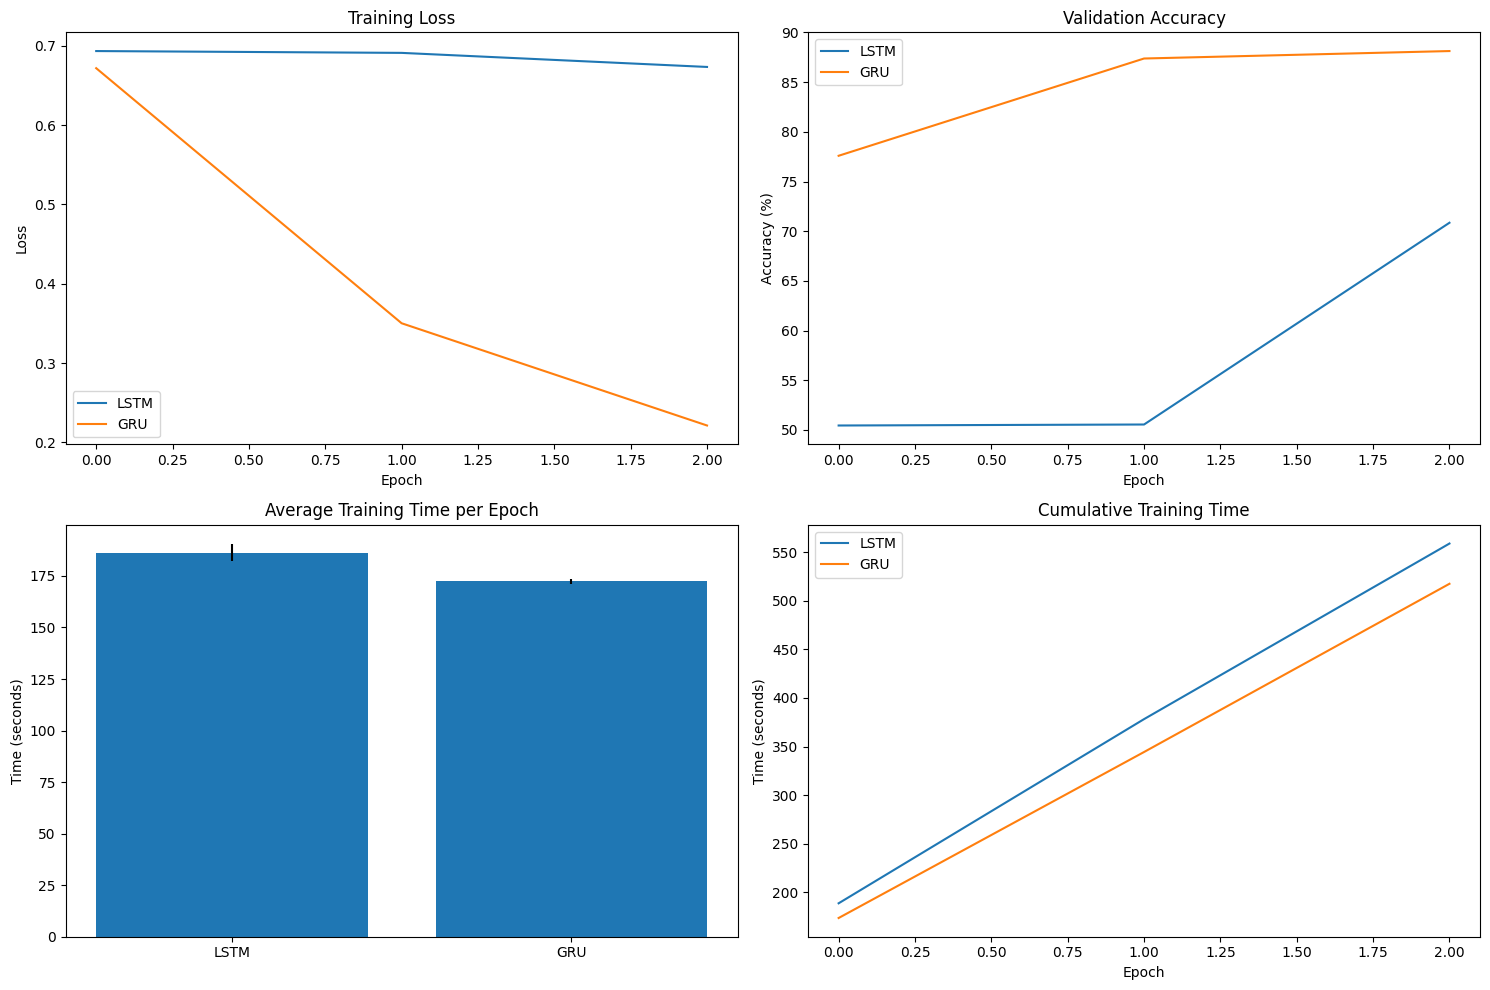

In [32]:
history = compare_models()
visualize_comparison(history) 